In [1]:
"""The planar imaging module analyzes phantom images taken with the kV or MV imager in 2D.
The following phantoms are supported:

* Leeds TOR 18
* Standard Imaging QC-3
* Las Vegas
* Doselab MC2 (MV & kV)

Features:

* **Automatic phantom localization** - Set up your phantom any way you like; automatic positioning,
  angle, and inversion correction mean you can set up how you like, nor will setup variations give you headache.
* **High and low contrast determination** - Analyze both low and high contrast ROIs. Set thresholds
  as you see fit.
"""
import copy
import warnings
from functools import lru_cache
import io

import matplotlib.pyplot as plt
import numpy as np
from skimage import feature, measure

from pylinac.core.mtf import MTF
from pylinac.core.utilities import open_path
from pylinac.core import image
from pylinac.core.geometry import Point, Rectangle, Circle
from pylinac.core.io import get_url, retrieve_demo_file
from pylinac.core.profile import CollapsedCircleProfile
from pylinac.core.roi import LowContrastDiskROI, HighContrastDiskROI, bbox_center
from pylinac.core import pdf
from pylinac.core import geometry
from pprint import pprint

class ImagePhantomBase:
    """Base class for planar phantom classes.

    Attributes
    ----------
    common_name : str
        The human-readable name of the phantom. Used in plots and PDF report.
    phantom_outline_object : {None, 'Circle', 'Rectangle'}
        What type of outline to display on the plotted image. Helps to visually determine the accuracy of the
        phantom size, position, and scale.
    high_contrast_rois : list
        :class:`~pylinac.core.roi.HighContrastDiskROI` instances of the
        high contrast line pair regions.
    high_contrast_roi_settings : dict
        Settings of the placement of the high-contrast ROIs.
    low_contrast_rois : list
        :class:`~pylinac.core.roi.LowContrastDiskROI` instances of the low
        contrast ROIs, other than the reference ROI (below).
    low_contrast_roi_settings : dict
        Settings of the placement of the low-contrast ROIs.
    low_contrast_background_rois : list
        :class:`~pylinac.core.roi.LowContrastDiskROI` instances of the low
        contrast background ROIs.
    low_contrast_background_roi_settings : dict
        Settings of the placement of the background low-contrast ROIs.
    low_contrast_background_value : float
        The average pixel value of all the low-contrast background ROIs.
    """
    _demo_filename = ''
    common_name = ''
    high_contrast_roi_settings = {}
    high_contrast_rois = []
    low_contrast_roi_settings = {}
    low_contrast_rois = []
    low_contrast_background_roi_settings = {}
    low_contrast_background_rois = []
    low_contrast_background_value = None
    phantom_outline_object = None

    def __init__(self, filepath: str):
        """
        Parameters
        ----------
        filepath : str
            Path to the image file.
        """
        self.image = image.load(filepath)
        self.image.invert()
        self.image.ground()
        self.image.normalize()
        self._angle_override = None
        self._size_override = None
        self._center_override = None
        self._high_contrast_threshold = None
        self._low_contrast_threshold = None
        self.mtf = None

    @classmethod
    def from_demo_image(cls):
        """Instantiate and load the demo image."""
        demo_file = retrieve_demo_file(url=cls._demo_filename)
        return cls(demo_file)

    @classmethod
    def from_url(cls, url):
        """
        Parameters
        ----------
        url : str
            The URL to the image.
        """
        image_file = get_url(url)
        return cls(image_file)

    def _preprocess(self):
        pass

    def _check_inversion(self):
        pass

    def analyze(self, low_contrast_threshold=0.05, high_contrast_threshold=0.5, invert=False, angle_override=None,
                center_override=None, size_override=None) -> None:
        """Analyze the phantom using the provided thresholds and settings.

        Parameters
        ----------
        low_contrast_threshold : float
            This is the contrast threshold value which defines any low-contrast ROI as passing or failing.
        high_contrast_threshold : float
            This is the contrast threshold value which defines any high-contrast ROI as passing or failing.
        invert : bool
            Whether to force an inversion of the image. This is useful if pylinac's automatic inversion algorithm fails
            to properly invert the image.
        angle_override : None, float
            A manual override of the angle of the phantom. If None, pylinac will automatically determine the angle. If
            a value is passed, this value will override the automatic detection.

            .. Note::

                0 is pointing from the center toward the right and positive values go counterclockwise.

        center_override : None, 2-element tuple
            A manual override of the center point of the phantom. If None, pylinac will automatically determine the center. If
            a value is passed, this value will override the automatic detection. Format is (x, y)/(col, row).
        size_override : None, float
            A manual override of the relative size of the phantom. This size value is used to scale the positions of
            the ROIs from the center. If None, pylinac will automatically determine the size.
            If a value is passed, this value will override the automatic sizing.

            .. Note::

                 This value is not necessarily the physical size of the phantom. It is an arbitrary value.
        """
        self._angle_override = angle_override
        self._center_override = center_override
        self._size_override = size_override
        self._high_contrast_threshold = high_contrast_threshold
        self._low_contrast_threshold = low_contrast_threshold
        self._check_inversion()
        if invert:
            self.image.invert()
        self._preprocess()
        if self.high_contrast_roi_settings:
            self.high_contrast_rois = self._sample_high_contrast_rois()
            # generate rMTF
            spacings = [roi['lp/mm'] for roi in self.high_contrast_roi_settings.values()]
            self.mtf = MTF.from_high_contrast_diskset(diskset=self.high_contrast_rois, spacings=spacings)
        if self.low_contrast_background_roi_settings:
            self.low_contrast_background_rois, self.low_contrast_background_value = self._sample_low_contrast_background_rois()
        if self.low_contrast_roi_settings:
            self.low_contrast_rois = self._sample_low_contrast_rois()

    def _sample_low_contrast_rois(self):
        """Sample the low-contrast sample regions for calculating contrast values."""
        lc_rois = []
        for stng in self.low_contrast_roi_settings.values():
            roi = LowContrastDiskROI(self.image,
                                     self.phantom_angle + stng['angle'],
                                     self.phantom_radius * stng['roi radius'],
                                     self.phantom_radius * stng['distance from center'],
                                     self.phantom_center,
                                     self._low_contrast_threshold,
                                     self.low_contrast_background_value)
            lc_rois.append(roi)
        return lc_rois

    def _sample_low_contrast_background_rois(self):
        """Sample the low-contrast background regions for calculating contrast values."""
        bg_rois = []
        for stng in self.low_contrast_background_roi_settings.values():
            roi = LowContrastDiskROI(self.image,
                                     self.phantom_angle + stng['angle'],
                                     self.phantom_radius * stng['roi radius'],
                                     self.phantom_radius * stng['distance from center'],
                                     self.phantom_center,
                                     self._low_contrast_threshold)
            bg_rois.append(roi)
        avg_bg = np.mean([roi.pixel_value for roi in bg_rois])
        return bg_rois, avg_bg

    def _sample_high_contrast_rois(self):
        """Sample the high-contrast line pair regions."""
        hc_rois = []
        for stng in self.high_contrast_roi_settings.values():
            roi = HighContrastDiskROI(self.image,
                                      self.phantom_angle + stng['angle'],
                                      self.phantom_radius * stng['roi radius'],
                                      self.phantom_radius * stng['distance from center'],
                                      self.phantom_center,
                                      self._high_contrast_threshold)
            hc_rois.append(roi)
        return hc_rois

    def save_analyzed_image(self, filename: str, **kwargs):
        """Save the analyzed image to a file.

        Parameters
        ----------
        filename : str
            The location and filename to save to.
        kwargs
            Keyword arguments are passed to plt.savefig().
        """
        self.plot_analyzed_image(show=False, **kwargs)
        plt.savefig(filename, **kwargs)

    def _get_canny_regions(self, sigma=2, percentiles=(0.001, 0.01)):
        """Compute the canny edges of the image and return the connected regions found."""
        # copy, filter, and ground the image
        img_copy = copy.copy(self.image)
        img_copy.filter(kind='gaussian', size=sigma)
        img_copy.ground()

        # compute the canny edges with very low thresholds (detects nearly everything)
        lo_th, hi_th = np.percentile(img_copy, percentiles)
        c = feature.canny(img_copy, low_threshold=lo_th, high_threshold=hi_th)

        # label the canny edge regions
        labeled = measure.label(c)
        regions = measure.regionprops(labeled, intensity_image=img_copy)
        return regions

    def _create_phantom_outline_object(self):
        """Construct the phantom outline object which will be plotted on the image for visual inspection."""
        outline_type = list(self.phantom_outline_object)[0]
        outline_settings = list(self.phantom_outline_object.values())[0]
        settings = {}
        if outline_type == 'Rectangle':
            side_a = self.phantom_radius*outline_settings['width ratio']
            side_b = self.phantom_radius*outline_settings['height ratio']
            half_hyp = np.sqrt(side_a**2 + side_b**2)/2
            internal_angle = ia = np.rad2deg(np.arctan(side_b/side_a))
            new_x = self.phantom_center.x + half_hyp*(geometry.cos(ia)-geometry.cos(ia+self.phantom_angle))
            new_y = self.phantom_center.y + half_hyp*(geometry.sin(ia)-geometry.sin(ia+self.phantom_angle))
            obj = Rectangle(width=self.phantom_radius*outline_settings['width ratio'],
                            height=self.phantom_radius*outline_settings['height ratio'],
                            center=Point(new_x, new_y))
            settings['angle'] = self.phantom_angle
        elif outline_type == 'Circle':
            obj = Circle(center_point=self.phantom_center,
                         radius=self.phantom_radius*outline_settings['radius ratio'])
        else:
            raise ValueError("An outline object was passed but was not a Circle or Rectangle.")
        return obj, settings

    def plot_analyzed_image(self, image=True, low_contrast=True, high_contrast=True, show=True):
        """Plot the analyzed image.

        Parameters
        ----------
        image : bool
            Show the image.
        low_contrast : bool
            Show the low contrast values plot.
        high_contrast : bool
            Show the high contrast values plot.
        show : bool
            Whether to actually show the image when called.
        """
        plot_low_contrast = low_contrast and any(self.low_contrast_rois)
        plot_high_contrast = high_contrast and any(self.high_contrast_rois)
        num_plots = sum((image, plot_low_contrast, plot_high_contrast))
        if num_plots < 1:
            warnings.warn("Nothing was plotted because either all parameters were false or there were no actual high/low ROIs")
            return
        # set up axes and make axes iterable
        fig, axes = plt.subplots(1, num_plots)
        fig.subplots_adjust(wspace=0.4)
        if num_plots < 2:
            axes = (axes,)
        axes = iter(axes)

        # plot the marked image
        if image:
            img_ax = next(axes)
            self.image.plot(ax=img_ax, show=False)
            # self.image.plot(ax=img_ax, show=False)
            img_ax.axis('off')
            img_ax.set_title(f'{self.common_name} Phantom Analysis')

            # plot the outline image
            if self.phantom_outline_object is not None:
                outline_obj, settings = self._create_phantom_outline_object()
                outline_obj.plot2axes(img_ax, edgecolor='g', **settings)
            # plot the low contrast background ROIs
            for roi in self.low_contrast_background_rois:
                roi.plot2axes(img_ax, edgecolor='g')
            # plot the low contrast ROIs
            for roi in self.low_contrast_rois:
                roi.plot2axes(img_ax, edgecolor=roi.plot_color)
            # plot the high-contrast ROIs along w/ pass/fail coloration
            if self.high_contrast_rois:
                for (roi, mtf) in zip(self.high_contrast_rois, self.mtf.norm_mtfs.values()):
                    color = 'b' if mtf > self._high_contrast_threshold else 'r'
                    roi.plot2axes(img_ax, edgecolor=color)

        # plot the low contrast value graph
        if plot_low_contrast:
            lowcon_ax = next(axes)
            self._plot_lowcontrast_graph(lowcon_ax)

        # plot the high contrast MTF graph
        if plot_high_contrast:
            hicon_ax = next(axes)
            self._plot_highcontrast_graph(hicon_ax)

        if show:
            plt.show()

    def _plot_lowcontrast_graph(self, axes):
        """Plot the low contrast ROIs to an axes."""
        line1, = axes.plot([roi.contrast for roi in self.low_contrast_rois], marker='o', color='m', label='Contrast')
        axes.axhline(self._low_contrast_threshold, color='m')
        axes.grid(True)
        axes.set_title('Low-frequency Contrast')
        axes.set_xlabel('ROI #')
        axes.set_ylabel('Contrast')
        axes2 = axes.twinx()
        line2, = axes2.plot([roi.contrast_to_noise for roi in self.low_contrast_rois], marker='^', label='CNR')
        axes2.set_ylabel('CNR')
        axes.legend(handles=[line1, line2])

    def _plot_highcontrast_graph(self, axes):
        """Plot the high contrast ROIs to an axes."""
        axes.plot(self.mtf.spacings, list(self.mtf.norm_mtfs.values()), marker='*')
        axes.axhline(self._high_contrast_threshold, color='k')
        axes.grid(True)
        axes.set_title('High-frequency rMTF')
        axes.set_xlabel('Line pairs / mm')
        axes.set_ylabel('relative MTF')

    def results(self) -> str:
        """Return the results of the analysis. """
        text = [f'{self.common_name} results:',
                f'File: {self.image.truncated_path}'
        ]
        if self.low_contrast_rois:
            text += [
                    f'Median Contrast: {np.median([roi.contrast for roi in self.low_contrast_rois]):2.2f}',
                    f'Median CNR: {np.median([roi.contrast_to_noise for roi in self.low_contrast_rois]):2.1f}',
                    f'# Low contrast ROIs "seen": {sum(roi.passed for roi in self.low_contrast_rois):2.0f} of {len(self.low_contrast_rois)}',
            ]
        if self.high_contrast_rois:
            text += [f'MTF 80% (lp/mm): {self.mtf.relative_resolution(80):2.2f}',
                     f'MTF 50% (lp/mm): {self.mtf.relative_resolution(50):2.2f}',
                     f'MTF 30% (lp/mm): {self.mtf.relative_resolution(30):2.2f}',
            ]
        return text

    def publish_pdf(self, filename: str, notes=None, open_file=False, metadata=None):
        """Publish (print) a PDF containing the analysis, images, and quantitative results.

        Parameters
        ----------
        filename : (str, file-like object}
            The file to write the results to.
        notes : str, list of strings
            Text; if str, prints single line.
            If list of strings, each list item is printed on its own line.
        open_file : bool
            Whether to open the file using the default program after creation.
        metadata : dict
            Extra data to be passed and shown in the PDF. The key and value will be shown with a colon.
            E.g. passing {'Author': 'James', 'Unit': 'TrueBeam'} would result in text in the PDF like:
            --------------
            Author: James
            Unit: TrueBeam
            --------------
        """
        canvas = pdf.PylinacCanvas(filename, page_title=f'{self.common_name} Phantom Analysis', metadata=metadata)

        # write the text/numerical values
        text = self.results()
        canvas.add_text(text=text, location=(1.5, 25), font_size=14)
        if notes is not None:
            canvas.add_text(text="Notes:", location=(1, 5.5), font_size=12)
            canvas.add_text(text=notes, location=(1, 5))

        # plot the image
        data = io.BytesIO()
        self.save_analyzed_image(data, image=True, low_contrast=False, high_contrast=False)
        canvas.add_image(data, location=(1, 3.5), dimensions=(19, 19))
        # plot the high contrast
        if self.high_contrast_rois:
            canvas.add_new_page()
            data = io.BytesIO()
            self.save_analyzed_image(data, image=False, low_contrast=False, high_contrast=True)
            canvas.add_image(data, location=(1, 7), dimensions=(19, 19))
        # plot the low contrast
        if self.low_contrast_rois:
            canvas.add_new_page()
            data = io.BytesIO()
            self.save_analyzed_image(data, image=False, low_contrast=True, high_contrast=False)
            canvas.add_image(data, location=(1, 7), dimensions=(19, 19))

        canvas.finish()
        if open_file:
            open_path(filename)

    @property
    def phantom_center(self):
        return Point(self._center_override) if self._center_override is not None else self._phantom_center_calc()

    @property
    def phantom_radius(self):
        return self._size_override if self._size_override is not None else self._phantom_radius_calc()

    @property
    def phantom_angle(self):
        return self._angle_override if self._angle_override is not None else self._phantom_angle_calc()

    def _phantom_center_calc(self):
        pass

    def _phantom_angle_calc(self):
        pass

    def _phantom_radius_calc(self):
        pass


class LasVegas(ImagePhantomBase):
    _demo_filename = 'lasvegas.dcm'
    common_name = 'Las Vegas'
    _phantom_ski_region = None
    phantom_outline_object = {'Rectangle': {'width ratio': 0.62, 'height ratio': 0.62}}
    low_contrast_background_roi_settings = {
        'roi 1': {'distance from center': 0.24, 'angle': 0, 'roi radius': 0.03},
        'roi 2': {'distance from center': 0.24, 'angle': 90, 'roi radius': 0.03},
        'roi 3': {'distance from center': 0.24, 'angle': 180, 'roi radius': 0.03},
        'roi 4': {'distance from center': 0.24, 'angle': 270, 'roi radius': 0.03},
    }
    low_contrast_roi_settings = {
        'roi 1': {'distance from center': 0.107, 'angle': 0.5, 'roi radius': 0.028},
        'roi 2': {'distance from center': 0.141, 'angle': 39.5, 'roi radius': 0.028},
        'roi 3': {'distance from center': 0.205, 'angle': 58, 'roi radius': 0.028},
        'roi 4': {'distance from center': 0.179, 'angle': -76.5, 'roi radius': 0.016},
        'roi 5': {'distance from center': 0.095, 'angle': -63.5, 'roi radius': 0.016},
        'roi 6': {'distance from center': 0.042, 'angle': 0.5, 'roi radius': 0.016},
        'roi 7': {'distance from center': 0.097, 'angle': 65.5, 'roi radius': 0.016},
        'roi 8': {'distance from center': 0.178, 'angle': 76.5, 'roi radius': 0.016},
        'roi 9': {'distance from center': 0.174, 'angle': -97.5, 'roi radius': 0.012},
        'roi 10': {'distance from center': 0.088, 'angle': -105.5, 'roi radius': 0.012},
        'roi 11': {'distance from center': 0.024, 'angle': -183.5, 'roi radius': 0.012},
        'roi 12': {'distance from center': 0.091, 'angle': 105.5, 'roi radius': 0.012},
        'roi 13': {'distance from center': 0.179, 'angle': 97.5, 'roi radius': 0.012},
        'roi 14': {'distance from center': 0.189, 'angle': -113.5, 'roi radius': 0.007},
        'roi 15': {'distance from center': 0.113, 'angle': -131.5, 'roi radius': 0.007},
        'roi 16': {'distance from center': 0.0745, 'angle': -181.5, 'roi radius': 0.007},
        'roi 17': {'distance from center': 0.115, 'angle': 130, 'roi radius': 0.007},
        'roi 18': {'distance from center': 0.191, 'angle': 113, 'roi radius': 0.007},
        'roi 19': {'distance from center': 0.2085, 'angle': -124.6, 'roi radius': 0.003},
        'roi 20': {'distance from center': 0.146, 'angle': -144.3, 'roi radius': 0.003},
    }

    @staticmethod
    def run_demo():
        """Run the Las Vegas phantom analysis demonstration."""
        lv = LasVegas.from_demo_image()
        lv.analyze()
        lv.plot_analyzed_image()

    def _preprocess(self):
        self._check_direction()

    def _check_inversion(self):
        """Check the inversion by using the histogram of the phantom region"""
        roi = self._phantom_ski_region_calc()
        phantom_array = self.image.array[roi.bbox[0]:roi.bbox[2], roi.bbox[1]:roi.bbox[3]]
        phantom_sub_image = image.load(phantom_array)
        phantom_sub_image.crop(int(phantom_sub_image.shape[0]*0.1))
        p5 = np.percentile(phantom_sub_image, 0.5)
        p50 = np.percentile(phantom_sub_image, 50)
        p95 = np.percentile(phantom_sub_image, 99.5)
        dist_to_5 = abs(p50 - p5)
        dist_to_95 = abs(p50 - p95)
        if dist_to_5 > dist_to_95:
            self.image.invert()

    def _check_direction(self) -> None:
        """Check that the phantom is facing the right direction and if not perform a left-right flip of the array."""
        circle = CollapsedCircleProfile(self.phantom_center, self.phantom_radius * 0.175, self.image, ccw=False,
                                        width_ratio=0.16, num_profiles=5)
        roll_amount = np.where(circle.values == circle.values.min())[0][0]
        circle.roll(roll_amount)
        circle.filter(size=0.015, kind='median')
        valleys = circle.find_peaks(max_number=2, kind='value')
        if valleys[0] > valleys[1]:
            self.image.array = np.fliplr(self.image.array)
            self._phantom_ski_region = None

    def _phantom_center_calc(self) -> Point:
        return bbox_center(self._phantom_ski_region_calc())

    def _phantom_radius_calc(self) -> float:
        return self._phantom_ski_region_calc().major_axis_length

    def _phantom_angle_calc(self) -> float:
        return 0.0

    def _phantom_ski_region_calc(self):
        """The skimage region of the phantom outline."""
        if self._phantom_ski_region is not None:
            return self._phantom_ski_region
        else:
            regions = self._get_canny_regions()
            blobs = []
            phantom_bbox_size_mm2 = 20260
            phantom_size_pix = phantom_bbox_size_mm2 * (self.image.dpmm ** 2)
            for phantom_idx, region in enumerate(regions):
                if region.bbox_area < 50:
                    continue
                is_near_iso = np.isclose(region.bbox_area, phantom_size_pix, rtol=0.05)
                is_on_panel = np.isclose(region.bbox_area, phantom_size_pix/2, rtol=0.05)
                if (not is_near_iso) and (not is_on_panel):
                    continue
                hollow = region.extent < 0.02
                near_center_y = np.isclose(region.centroid[0], self.image.center.y, rtol=0.1)
                near_center_x = np.isclose(region.centroid[1], self.image.center.x, rtol=0.1)
                if (is_near_iso or is_on_panel) and near_center_x and near_center_y and hollow:
                    blobs.append(phantom_idx)

            if not blobs or (len(blobs) != 1):
                raise ValueError("Unable to find the Las Vegas phantom in the image. Either the phantom 1) was not centered, 2) was not set at iso (e.g. it's directly on the panel), 3) has an artifact (e.g. couch, rails), or 4) is rotated (not at 0, 90, 180, 270).")

            self._phantom_ski_region = regions[blobs[0]]
            return regions[blobs[0]]


class StandardImagingQC3(ImagePhantomBase):
    _demo_filename = 'qc3.dcm'
    common_name = 'SI QC-3'
    phantom_outline_object = {'Rectangle': {'width ratio': 7.5, 'height ratio': 6}}
    high_contrast_roi_settings = {
        'roi 1': {'distance from center': 2.8, 'angle': 0, 'roi radius': 0.5, 'lp/mm': 0.1},
        'roi 2': {'distance from center': -2.8, 'angle': 0, 'roi radius': 0.5, 'lp/mm': 0.2},
        'roi 3': {'distance from center': 1.45, 'angle': 0, 'roi radius': 0.5, 'lp/mm': 0.25},
        'roi 4': {'distance from center': -1.45, 'angle': 0, 'roi radius': 0.5, 'lp/mm': 0.45},
        'roi 5': {'distance from center': 0, 'angle': 0, 'roi radius': 0.5, 'lp/mm': 0.76},
    }
    low_contrast_roi_settings = {
        'roi 1': {'distance from center': 2, 'angle': 90, 'roi radius': 0.5},
        'roi 2': {'distance from center': 2, 'angle': -90, 'roi radius': 0.5},
        'roi 3': {'distance from center': 2.4, 'angle': 55, 'roi radius': 0.5},
        'roi 4': {'distance from center': 2.4, 'angle': -55, 'roi radius': 0.5},
        'roi 5': {'distance from center': 2.4, 'angle': 128, 'roi radius': 0.5},
        'roi 6': {'distance from center': 2.4, 'angle': -128, 'roi radius': 0.5},
    }
    low_contrast_background_roi_settings = {
        'roi 1': {'distance from center': 2, 'angle': 90, 'roi radius': 0.5},
    }

    @staticmethod
    def run_demo() -> None:
        """Run the Standard Imaging QC-3 phantom analysis demonstration."""
        qc3 = StandardImagingQC3.from_demo_image()
        qc3.analyze()
        qc3.plot_analyzed_image()

    @property
    @lru_cache()
    def phantom_ski_region(self):
        """The skimage region of the phantom outline."""
        regions = self._get_canny_regions()
        blobs = []
        phantom_bbox_size_mm2 = 176**2  # phantom is 115 x 134 mm2. At 45degrees that's 176 x 176mm
        fudge_factor = 0.95  # in practice, the detected size is a little bit smaller
        phantom_size_pix = phantom_bbox_size_mm2 * (self.image.dpmm ** 2) * fudge_factor
        img_center = (self.image.center.y, self.image.center.x)
        for phantom_idx, region in enumerate(regions):
            if region.bbox_area < 1000:
                continue
            is_at_iso = np.isclose(region.bbox_area, phantom_size_pix, rtol=0.07)
            is_at_140cm = np.isclose(region.bbox_area, phantom_size_pix/(1.4**2), rtol=0.07)
            centered = np.allclose(region.centroid, img_center, rtol=0.1)
            if (is_at_iso or is_at_140cm) and centered:
                blobs.append(phantom_idx)

        if not blobs:
            raise ValueError("Unable to find the QC-3 phantom in the image.")

        # find the biggest ROI and call that the phantom outline
        big_roi_idx = np.argsort([regions[phan].major_axis_length for phan in blobs])[-1]
        phantom_idx = blobs[big_roi_idx]

        return regions[phantom_idx]

    def _phantom_radius_calc(self) -> float:
        """The radius of the phantom in pixels; the value itself doesn't matter, it's just
        used for relative distances to ROIs.

        Returns
        -------
        radius : float
        """
        return self.phantom_ski_region.major_axis_length / 14

    def _phantom_angle_calc(self) -> float:
        """The angle of the phantom. This assumes the user is using the stand that comes with the phantom,
        which angles the phantom at 45 degrees.

        Returns
        -------
        angle : float
            The angle in degrees.
        """
        return 45.0

    def _phantom_center_calc(self) -> Point:
        """The center point of the phantom.

        Returns
        -------
        center : Point
        """
        return bbox_center(self.phantom_ski_region)


class LeedsTOR(ImagePhantomBase):
    _demo_filename = 'leeds.dcm'
    common_name = 'Leeds'
    _phantom_angle = None
    _phantom_center = None
    phantom_outline_object = {'Circle': {'radius ratio': 0.97}}
    high_contrast_roi_settings = {
        'roi 1': {'distance from center': 0.9, 'angle': -35, 'roi radius': 0.04, 'lp/mm': 0.5},
        'roi 2': {'distance from center': 0.8, 'angle': -55, 'roi radius': 0.04, 'lp/mm': 0.56},
        #'roi 3': {'distance from center': 0.2, 'angle': -45, 'roi radius': 0.04, 'lp/mm': 0.4},
        #'roi 4': {'distance from center': 0.04, 'angle': 0, 'roi radius': 0.04, 'lp/mm': 0.3},
        #'roi 5': {'distance from center': -0.3, 'angle': 20, 'roi radius': 0.04, 'lp/mm': 0.2},
        #'roi 6': {'distance from center': -0.4, 'angle': 35, 'roi radius': 0.04, 'lp/mm': 0.21},
        #'roi 7': {'distance from center': -0.6, 'angle': 35, 'roi radius': 0.04, 'lp/mm': 0.22},
        #'roi 8': {'distance from center': -0.1, 'angle': 35, 'roi radius': 0.04, 'lp/mm': 0.23},
    }
    low_contrast_background_roi_settings = {
 
    }
    low_contrast_roi_settings = {
         
    }

    @property
    @lru_cache(1)
    def _blobs(self):
        """The indices of the regions that were significant; i.e. a phantom circle outline or lead/copper square."""
        blobs = []
        for idx, region in enumerate(self._regions):
            if region.area < 100:
                continue
            round = region.eccentricity < 0.3
            if round:
                blobs.append(idx)
        if not blobs:
            raise ValueError("Could not find the phantom in the image.")
        return blobs

    @property
    @lru_cache(1)
    def _regions(self):
        """All the regions of the canny image that were labeled."""
        return self._get_canny_regions()

    def _phantom_center_calc(self) -> Point:
        """Determine the phantom center.

        This is done by searching for circular ROIs of the canny image. Those that are circular and roughly the
        same size as the biggest circle ROI are all sampled for the center of the bounding box. The values are
        averaged over all the detected circles to give a more robust value.

        Returns
        -------
        center : Point
        """
        if self._phantom_center is not None:
            return self._phantom_center
        circles = [roi for roi in self._blobs if
                   np.isclose(self._regions[roi].major_axis_length, self.phantom_radius * 3.35, rtol=0.3)]

        # get average center of all circles
        circle_rois = [self._regions[roi] for roi in circles]
        y = np.mean([bbox_center(roi).y for roi in circle_rois])
        x = np.mean([bbox_center(roi).x for roi in circle_rois])
        return Point(x, y)

    def _phantom_angle_calc(self) -> float:
        """Determine the angle of the phantom.

        This is done by searching for square-like boxes of the canny image. There are usually two: one lead and
        one copper. The box with the highest intensity (lead) is identified. The angle from the center of the lead
        square bounding box and the phantom center determines the phantom angle.

        Returns
        -------
        angle : float
            The angle in radians.
        """
        circle = CollapsedCircleProfile(self.phantom_center, self.phantom_radius * 0.79, self.image,
                                        width_ratio=0.04, ccw=True)
        circle.ground()
        circle.filter(size=0.01)
        peak_idx = circle.find_fwxm_peaks(threshold=0.6, max_number=1)[0]
        shift_percent = peak_idx / len(circle.values)
        shift_radians = shift_percent * 2 * np.pi
        shift_radians_corrected = 2*np.pi - shift_radians
        return np.degrees(shift_radians_corrected)

    def _phantom_radius_calc(self) -> float:
        """Determine the radius of the phantom.

        The radius is determined by finding the largest of the detected blobs of the canny image and taking
        its major axis length.

        Returns
        -------
        radius : float
            The radius of the phantom in pixels. The actual value is not important; it is used for scaling the
            distances to the low and high contrast ROIs.
        """
        big_circle_idx = np.argsort([self._regions[roi].major_axis_length for roi in self._blobs])[-1]
        circle_roi = self._regions[self._blobs[big_circle_idx]]
        radius = circle_roi.major_axis_length / 3.35
        return radius

    def _is_counter_clockwise(self) -> bool:
        """Determine if the low-contrast bubbles go from high to low clockwise or counter-clockwise.

        Returns
        -------
        boolean
        """
        circle = CollapsedCircleProfile(self.phantom_center, self.phantom_radius * 0.79, self.image, width_ratio=0.04, ccw=True)
        circle.ground()
        circle.filter(size=0.01)
        circle.values = np.roll(circle.values, -circle.values.argmax())
        first_set = circle.find_peaks(search_region=(0.05, 0.45), threshold=0, min_distance=0.025, kind='value', max_number=9)
        second_set = circle.find_peaks(search_region=(0.55, 0.95), threshold=0, min_distance=0.025, kind='value', max_number=9)
        return max(first_set) > max(second_set)

    @staticmethod
    def run_demo() -> None:
        """Run the Leeds TOR phantom analysis demonstration."""
        leeds = LeedsTOR.from_demo_image()
        leeds.analyze()
        leeds.plot_analyzed_image()

    def _preprocess(self) -> None:
        self.image.check_inversion_by_histogram()
        if self._is_counter_clockwise():
            self._flip_image_data()

    def _flip_image_data(self) -> None:
        """Flip the image left->right and invert the center, and angle as appropriate.

        Sometimes the Leeds phantom is set upside down on the imaging panel. Pylinac's
        analysis goes counter-clockwise, so this method flips the image and coordinates to
        make the image ccw. Quicker than flipping the image and reanalyzing.
        """
        self.image.array = np.fliplr(self.image.array)
        new_x = self.image.shape[1] - self.phantom_center.x
        self._phantom_center = Point(new_x, self.phantom_center.y)


class DoselabMC2kV(ImagePhantomBase):
    common_name = "Doselab MC2 kV"
    _demo_filename = 'Doselab_kV.dcm'
    phantom_outline_object = {'Rectangle': {'width ratio': 0.55, 'height ratio': 0.63}}
    low_contrast_background_roi_settings = {
        'roi 1': {'distance from center': 0.14, 'angle': 36, 'roi radius': 0.02},
    }
    low_contrast_roi_settings = {
        'roi 1': {'distance from center': 0.265, 'angle': 48, 'roi radius': 0.025},
        'roi 2': {'distance from center': 0.215, 'angle': 64.5, 'roi radius': 0.025},
        'roi 3': {'distance from center': 0.19, 'angle': 89, 'roi radius': 0.025},
        'roi 4': {'distance from center': 0.205, 'angle': 113, 'roi radius': 0.025},
    }
    high_contrast_roi_settings = {
        'roi 1': {'distance from center': 0.17, 'angle': -20, 'roi radius': 0.013, 'lp/mm': 0.6},
        'roi 2': {'distance from center': 0.16, 'angle': -2, 'roi radius': 0.007, 'lp/mm': 1.2},
        'roi 3': {'distance from center': 0.164, 'angle': 12.8, 'roi radius': 0.005, 'lp/mm': 1.8},
        'roi 4': {'distance from center': 0.175, 'angle': 24.7, 'roi radius': 0.0035, 'lp/mm': 2.4},
    }

    @staticmethod
    def run_demo() -> None:
        """Run the Doselab MC2 kV-area phantom analysis demonstration."""
        leeds = DoselabMC2kV.from_demo_image()
        leeds.analyze()
        leeds.plot_analyzed_image()

    @property
    @lru_cache()
    def phantom_ski_region(self):
        """The skimage region of the phantom outline."""
        regions = self._get_canny_regions(percentiles=(0.01, 0.1))
        blobs = []
        phantom_bbox_size_mm2 = 26300
        phantom_size_pix = phantom_bbox_size_mm2 * (self.image.dpmm ** 2)
        for phantom_idx, region in enumerate(regions):
            if not np.isclose(phantom_size_pix, region.bbox_area, rtol=0.1):
                continue
            hollow = region.extent < 0.05
            if hollow:
                blobs.append(phantom_idx)

        if not blobs or (len(blobs) != 1):
            raise ValueError("Unable to find the Doselab phantom in the image.")

        return regions[blobs[0]]

    def _phantom_center_calc(self) -> Point:
        roi = self.phantom_ski_region
        return Point(roi.centroid[1], roi.centroid[0])

    def _phantom_radius_calc(self) -> float:
        return self.phantom_ski_region.major_axis_length

    def _phantom_angle_calc(self) -> float:
        roi = self.phantom_ski_region
        angle = np.degrees(roi.orientation) + 90
        if not np.isclose(angle, 45, atol=5):
            raise ValueError("Angles not close enough to the ideal 45 degrees. Check phantom setup or override angle.")
        return angle


class DoselabMC2MV(DoselabMC2kV):
    common_name = 'Doselab MC2 MV'
    _demo_filename = 'Doselab_MV.dcm'
    low_contrast_background_roi_settings = {
        'roi 1': {'distance from center': 0.14, 'angle': -138, 'roi radius': 0.02},
    }
    low_contrast_roi_settings = {
        'roi 1': {'distance from center': 0.27, 'angle': -48.5, 'roi radius': 0.025},
        'roi 2': {'distance from center': 0.225, 'angle': -65, 'roi radius': 0.025},
        'roi 3': {'distance from center': 0.205, 'angle': -88.5, 'roi radius': 0.025},
        'roi 4': {'distance from center': 0.22, 'angle': -110, 'roi radius': 0.025},
    }
    high_contrast_roi_settings = {
        'roi 1': {'distance from center': 0.23, 'angle': -135.3, 'roi radius': 0.012, 'lp/mm': 0.1},
        'roi 2': {'distance from center': 0.173, 'angle': 161, 'roi radius': 0.012, 'lp/mm': 0.2},
        'roi 3': {'distance from center': 0.237, 'angle': 133, 'roi radius': 0.012, 'lp/mm': 0.4},
        'roi 4': {'distance from center': 0.298, 'angle': 122.9, 'roi radius': 0.01, 'lp/mm': 0.8},
    }

    @staticmethod
    def run_demo() -> None:
        """Run the Doselab MC2 MV-area phantom analysis demonstration."""
        leeds = DoselabMC2MV.from_demo_image()
        leeds.analyze()
        leeds.plot_analyzed_image()

/home/jovyan/work/pylinac/kv_phantom/pylinac/core/mtf.py:40: UserWarning: The MTF does not drop monotonically; be sure the ROIs are correctly aligned.
  warnings.warn("The MTF does not drop monotonically; be sure the ROIs are correctly aligned.")


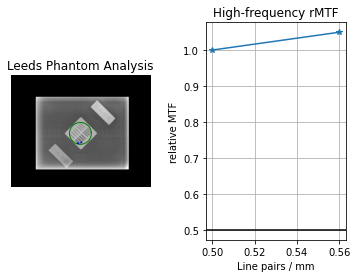

In [2]:
leeds = LeedsTOR('dcm/Raio-X_Movel_Setor_1/QIRXMOVELS1_20201019010001__966595/00000000')
leeds.analyze(0.01, 0.5)
leeds.plot_analyzed_image() 




In [8]:
"""



leeds = LeedsTOR('dcm/Raio-X_PS/QIRXPS_20201019010001__966599/00000000')
leeds.analyze(0.01, 0.5)
leeds.plot_analyzed_image() 




leeds = LeedsTOR('dcm/Raio-X_Movel_Setor_2/QIRXMOVELSETOR2_20201019010002__966601/00000000')
leeds.analyze(0.01, 0.5)
leeds.plot_analyzed_image() 




leeds = LeedsTOR('dcm/Raio-X_Sala_2/QIRxCDISala2_20201019010002__966574/00000000')
leeds.analyze(0.01, 0.5)
leeds.plot_analyzed_image() 



leeds = LeedsTOR('dcm/Raio-X_Sala_1/QIRXSala1_20201019010001__966564/00000000')
leeds.analyze(0.01, 0.5)
leeds.plot_analyzed_image() 



leeds = LeedsTOR('dcm/Raio-X_PS/QIRXPS_20201019010001__966599/00000000')
leeds.analyze(0.01, 0.5)
leeds.plot_analyzed_image() 



leeds = LeedsTOR('dcm/Raio-X_Movel_CC/QIRXMOVELCC_20201019010003__966620/00000000')
leeds.analyze(0.01, 0.5)
leeds.plot_analyzed_image() 



"""

"\n\n\n\nleeds = LeedsTOR('dcm/Raio-X_PS/QIRXPS_20201019010001__966599/00000000')\nleeds.analyze(0.01, 0.5)\nleeds.plot_analyzed_image() \n\n\n\n\nleeds = LeedsTOR('dcm/Raio-X_Movel_Setor_2/QIRXMOVELSETOR2_20201019010002__966601/00000000')\nleeds.analyze(0.01, 0.5)\nleeds.plot_analyzed_image() \n\n\n\n\nleeds = LeedsTOR('dcm/Raio-X_Sala_2/QIRxCDISala2_20201019010002__966574/00000000')\nleeds.analyze(0.01, 0.5)\nleeds.plot_analyzed_image() \n\n\n\nleeds = LeedsTOR('dcm/Raio-X_Sala_1/QIRXSala1_20201019010001__966564/00000000')\nleeds.analyze(0.01, 0.5)\nleeds.plot_analyzed_image() \n\n\n\nleeds = LeedsTOR('dcm/Raio-X_PS/QIRXPS_20201019010001__966599/00000000')\nleeds.analyze(0.01, 0.5)\nleeds.plot_analyzed_image() \n\n\n\nleeds = LeedsTOR('dcm/Raio-X_Movel_CC/QIRXMOVELCC_20201019010003__966620/00000000')\nleeds.analyze(0.01, 0.5)\nleeds.plot_analyzed_image() \n\n\n\n"